In [4]:
import numpy as np
import scipy as sp
#import scipy.stats as sp_stats
import scipy.linalg as sp_linalg
import itertools as itt 

In [5]:
import matplotlib
matplotlib.use('nbagg')
%matplotlib inline
import matplotlib.pyplot as plt  
import matplotlib.colors as mplcolors
#from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from IPython.display import HTML

# Kernel methods in machine learning and statistics
## Exercise Sheet 2

In this exercise, the task is to use kernel ridge regression to restore an image from a downsampled version of lower resolution. As an additional difficulty, parts of the low resolution image are deleted.

The high resolution image ("image_true") is modelled as a function $f:[0,2\pi]\times [0,2\pi] \rightarrow \mathbb{R}$, so $X = [0,2\pi]\times [0,2\pi]$ in the notation of the lecture. Of course, the interval $[0,2\pi]$ has to be discretised; here we use a grid containing 64 points. You can see the high resolution image plotted below in Figure 1.

The low resolution image with a deleted part is plotted in Figure 2 and stored in "image". As alluded to in the first sentence, the task is to recover Figure 1 from the data in Figure 2 using kernel ridge regression. More specifically, think of the data ("training samples") from Figure 2 as $((x^{(i)}_1,x^{(i)}_2),y^{(i)})$, where $(x^{(i)}_1,x^{(i)}_2) = \mathbf{x}^{(i)}$ denotes the location of the $i$th pixel in Figure 2 (stored in "xgrid_data"), and $y^{(i)}$ corresponds to the corresponding function value ('colour'), stored in "image". Note that $i=1,\ldots,N_{train}$ runs through the pixels in Figure 2 NOT (!) including the deleted part.

1) Implement kernel ridge regression based on the squared exponential (see below) using the formula from the lecture

\begin{equation}
f^*(\mathbf{x}) = \sum_{i=1}^N \alpha_i k(\mathbf{x}^{(i)},\mathbf{x}),
\end{equation}

where

\begin{equation}
\mathbf{\alpha} = \left( k_{DD} +  \lambda I_{N_{train} \times N_{train}}\right)^{-1} \mathbf{y}.
\end{equation}

The function $f^*$ represents the restored image, that is, $f^*(\mathbf{x})$ is the function value ('colour') at $\mathbf{x} \in [0,2\pi]^2$.
You may extend the code below that sets up the matrix $k_{DD}$.

2) Vary the parameters $\lambda$ and $\sigma$, and make a few plots of the restored image with these values. Briefly discuss overfitting and underfitting. 
Can you find parameters that lead to an almost ideal recovery of the true image? 

3) The following result is known: Let $\sigma > 0$, and denote by $k_{\sigma}$ the squared exponential kernel with width $\sigma$ (see below). For any $f \in \mathcal{H}_{k_\sigma}$, we have that 
\begin{equation}
\lim_{\delta \rightarrow 0} \Vert f \Vert_{\mathcal{H}_{k_\delta}} = 0.
\end{equation}
Use the problem formulation of kernel ridge regression and this result to explain your observations in 2) for small kernel widths, and relate this to the phenomenon of overfitting.

In [6]:
# Image constructed from 2d fourier series on [0,2pi] X [0,2pi]
Nx_true = 64
hx_true = 2.0*np.pi / float(Nx_true)
Nx_data = 16
hx_data = 2.0*np.pi / float(Nx_data)
Nsum = 100
beta = 6
image_true = np.zeros((Nx_true, Nx_true))
xgrid_true = np.linspace(0.0, 2.0*np.pi-hx_true, Nx_true)
xgrid_data = np.linspace(0.0, 2.0*np.pi-hx_data, Nx_data)
for i,j in itt.product(range(1,Nsum), range(1,Nsum)):
    k1 = (i+1)//2
    k2 = (j+1)//2
    if i%2 == 0:
        v1 = np.sin(float(k1)*xgrid_true)
    else:
        v1 = np.cos(float(k1)*xgrid_true)
    if j%2 == 0:
        v2 = np.sin(float(k2)*xgrid_true)
    else:
        v2 = np.cos(float(k2)*xgrid_true)
    image_true += np.outer(v1/float(k1)**beta, v2/float(k2)**beta)

# Downsample and add noise
ds_skip = Nx_true//Nx_data
image = np.zeros((Nx_data, Nx_data))
for i,j in itt.product(range(Nx_data), range(Nx_data)):
    image[i,j] = np.average(image_true[i*ds_skip:(i+1)*ds_skip, j*ds_skip:(j+1)*ds_skip])
img_sigma = 0.5
image = image_true[::ds_skip, ::ds_skip] + img_sigma * np.random.randn(Nx_data, Nx_data)


# Delete part of the image
x1blank_0 = Nx_data//4
x1blank_1 = 3*Nx_data//4-1
x2blank_0 = Nx_data//5
x2blank_1 = 5*Nx_data//7-1

image[x2blank_0:x2blank_1+1, x1blank_0:x1blank_1+1] = 0.0

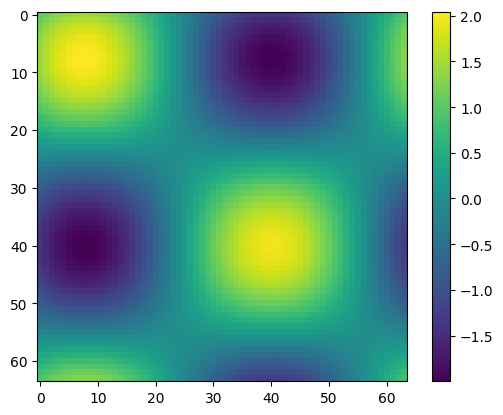

In [7]:
plt.imshow(image_true)
plt.colorbar()
plt.show()

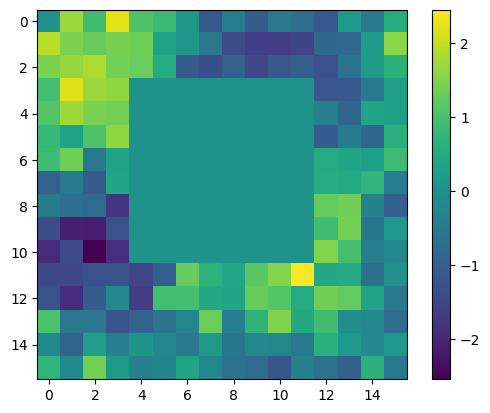

In [8]:
plt.imshow(image)
plt.colorbar()
plt.show()

Implement the squared exponential kernel function:
\begin{equation}
k(\mathbf{x},\mathbf{y}) = \exp \left( -\frac{|\mathbf{x} - \mathbf{y}|^2 }{\sigma^2}\right),  \qquad \mathbf{x},\mathbf{y} \in [0,2\pi]^2
\end{equation}

In [9]:
def kernel(x1, x2, sigma):
    return np.exp(-sp_linalg.norm(x1-x2, 2)**2/sigma**2)


In [16]:
# Kernel elements
#Nx = 64
#hx = 2.0*np.pi / float(Nx)
xgrid = np.linspace(0.0, 2.0*np.pi-hx_true, Nx_true)

Ntrain = Nx_data * Nx_data - (x1blank_1-x1blank_0+1) * (x2blank_1-x2blank_0+1)
Ntest = Nx_true * Nx_true

sigma = 2.0
def gram_matrix(sigma):
    k_DD = np.zeros((Ntrain, Ntrain))
    k_Dx = np.zeros((Ntrain, Ntest))

    # Compute k_DD and y
    k_DD = np.zeros((Ntrain, Ntrain))
    y = np.zeros(Ntrain)
    Xtrain = np.zeros((Ntrain,2))

    a = 0
    b = 0
    for i in range(Nx_data):
        for j in range(Nx_data):
            if i >= x2blank_0 and i <= x2blank_1 and j >= x1blank_0 and j <= x1blank_1:
                continue
            for k in range(Nx_data):
                for l in range(Nx_data):
                    if k >= x2blank_0 and k <= x2blank_1 and l >= x1blank_0 and l <= x1blank_1:
                        continue
                    x1 = np.array([xgrid_data[j], xgrid_data[i]])
                    x2 = np.array([xgrid_data[l], xgrid_data[k]])
                    k_DD[a,b] = kernel(x1, x2, sigma)
                    y[a] = image[j,i] 
                    Xtrain[a] = x1
                    b += 1
            b = 0
            a += 1
    return k_DD, y, Xtrain

k_DD, y, Xtrain = gram_matrix(sigma)

In [17]:
y[1],image[1,0] ,y.shape
x1 = xgrid_data[0], xgrid_data[0]
x2 = xgrid_data[0], xgrid_data[0]
image[0,0] == y[0]

True

In [21]:
l = 0.001
def coefficients(l):
    I = np.eye(Ntrain)
    M = np.linalg.inv(k_DD + l*I)
    alpha = np.dot(M,y)
    return alpha
Xtrain
alpha = coefficients(l)

In [19]:
def f_star(alpha, Xtrain, x, Ntrain, kernel, sigma):
    k = np.zeros(Ntrain)
    for i in range(Ntrain):
        k[i] = kernel(Xtrain[i], x, sigma)
    return np.dot(alpha, k)

In [14]:
f_star(alpha, Xtrain, np.array([0,0]), Ntrain, kernel, sigma), y[0]

(0.5494579260424359, -0.01870154124332446)

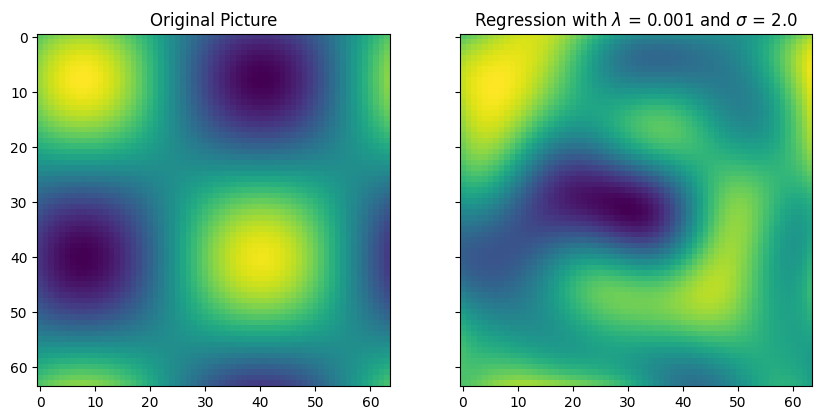

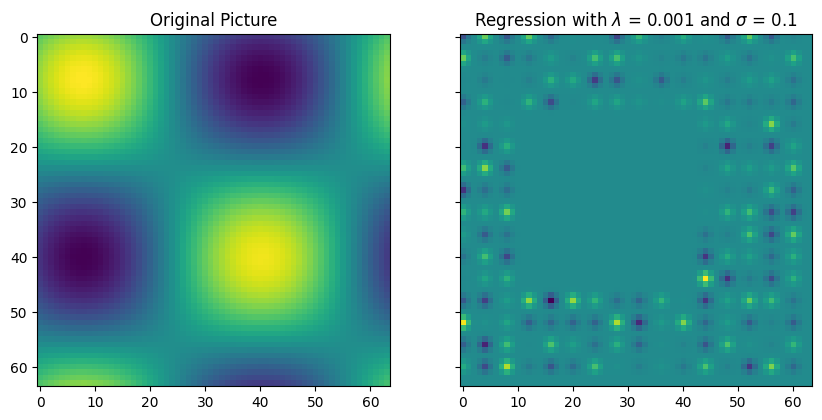

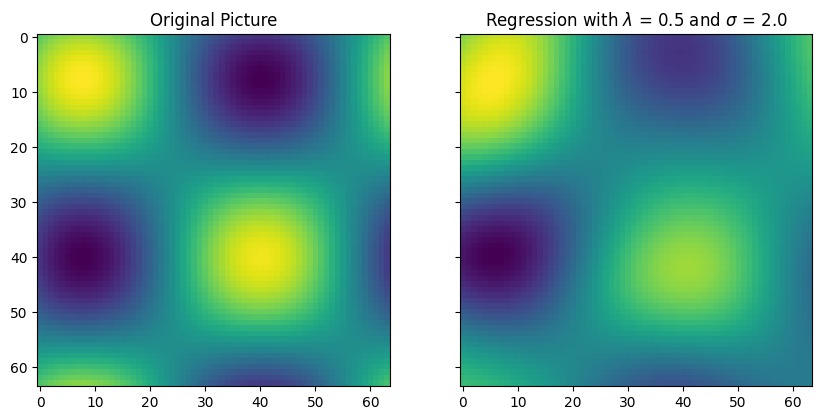

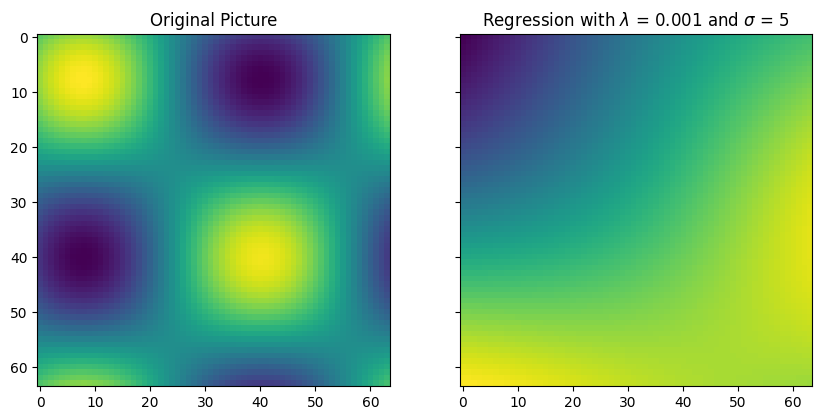

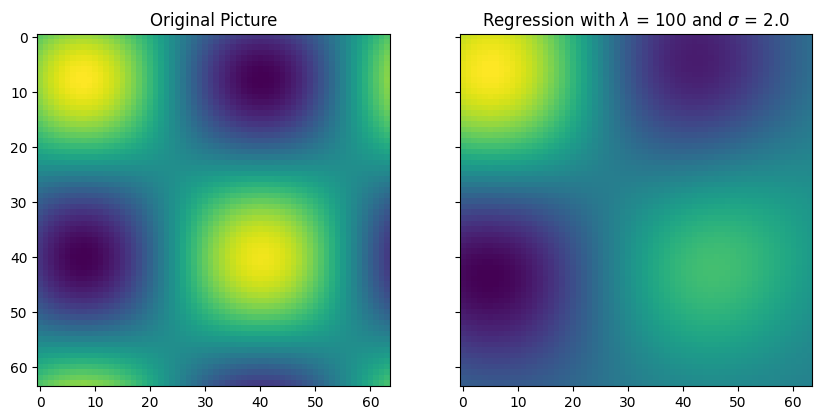

In [41]:
def ridge_regression(l, sigma):
    alpha = coefficients(l)
    image_regression = np.zeros((Nx_true, Nx_true))
    for i,j in itt.product(range(Nx_true), range(Nx_true)):
        x = np.array([xgrid_true[i], xgrid_true[j]])
        image_regression[i,j] = f_star(alpha, Xtrain, x, Ntrain, kernel, sigma)
    

#plt.imshow(image_regression)
#plt.colorbar()
#plt.show()

    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (10,10))
    #ax1.pcolormesh(image_regression)
    #ax2.pcolormesh(image_true)
    ax2.set_title(f"Regression with $\lambda$ = {l} and $\sigma$ = {sigma}")
    ax1.set_title(f"Original Picture")
    im2 = ax2.imshow(image_regression)
    im1 = ax1.imshow(image_true)
    cb1 = f.colorbar(im1)
    cb2 = f.colorbar(im2)
    cb1.remove()
    cb2.remove()

    plt.show()

ridge_regression(l,sigma) #small lambda
ridge_regression(l,0.1) #small sigma
ridge_regression(0.5,sigma) #best choice I have
ridge_regression(l,5) #big sigma
ridge_regression(100,sigma)#big lambda

# MAKE IT BIGGER, ADD TITLE/CAPTION WITH VALUES OF LAMBDA AND SIGMA, DO A LOOP TO PLOT OVER THE DIFFERENT VALUES, REFACTOR EVERYTHING INTO A FUNCTION